# Coefficient Estimation for NEWT

At this point, we have established that, with the available periods-of-record, a stationary SCHEMA works quite well, though some sort of dynamism is likely to help with longer-range applications.  Still, the emphasis is on short-term and S2S forecasting, so long-range efficiency isn't critical (and, more to the point, can be returned to later).  Now, let's look at coefficient estimation, where dynamic fitting is likely to be more important.

Here's the basic idea.  We want to be able to run a watershed model without pre-feeding years of data, but we also want to benefit from data on atmospheric conditions.  How should we proceed?

- Develop one fit for model coefficients based only on static surface conditions (XYZ, slope and aspect, land cover/LAI, drainage area)
- Develop a separate fit for model coefficients based only on dynamic conditions (mean precipitation, temperature, and humidity; land cover/LAI again; soil moisture; aridity)
- Tune two "drift rates": climate drift (rate of convergence from static-only to climate-only; possibly with a final equilibrium weighting), and recency weight (weighting of climate over time, controlling speed of correction for climate shifts)

For early reporting, I will prototype this with a single model accounting for all data.  Then, I'll build a static-only watershed model generator and a climate-drift model modification engine for the final implementation.

Data requirements:

- Model fits (have)
- Weather data (have)
- Land cover/LAI (have)
- Some kind of groundwater
- Topography summaries (have)
- Calculate aspect and slope (not avail for most watersheds, so need to calculate)
- Aridity or NDVI or something for dry years (need)

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics

In [2]:
def idfix(data):
    data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
    data["id"] = data["id"].apply(lambda x: x.split("_")[1])
    return data

In [3]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [4]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day_of_year
gsamp = pd.read_csv("GageSample.csv",
                   dtype={"id": "str"})
lcov = idfix(pd.read_csv("LandCover.csv"))
area = idfix(pd.read_csv("Area.csv"))
topo = idfix(pd.read_csv("Topography.csv"))
data = data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,wetland,ice_snow,area,elev,elev_min,elev_std,slope,asp,lat,lon
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992992,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992993,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992994,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992995,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444


## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [5]:
coefs = data.groupby("id").apply(lambda x: (
    pd.concat([
        Watershed.from_data(x).coefs_to_df().drop(columns=["R2", "RMSE"]),
        statics.fit_simple_daily(x, "tmax", True)
    ], axis=1)
) if len(x[["day", "temperature"]].dropna()["day"].unique()) >= 181 else None, include_groups=False)
coefs.index = coefs.index.get_level_values("id")
coefs

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,threshold_act_min,threshold_coef_min,threshold_act_cutoff,threshold_coef_max,intercept,ksin,kcos
id,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.393590,-1,0.002503,8,0.856937,8.787829,-6.067253,-15.167896
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.340676,-1,0.011190,5,0.734323,9.763696,-5.932321,-14.604735
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.451953,0,0.052588,3,0.832453,11.344458,-5.606314,-14.288229
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.468732,0,0.113039,4,0.726634,12.411499,-5.377854,-12.851322
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.415023,0,0.162370,15,0.708612,10.084860,-5.104671,-12.878405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.474400,1,-0.019589,11,0.545654,11.893447,-4.284127,-11.356781
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.320790,0,0.083988,3,0.491630,9.466164,-3.972916,-10.774711
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.404336,-1,-0.007609,2,0.486141,6.876817,-4.462743,-11.078878


In [8]:
coefs["coef_ratio"] = coefs["threshold_coef_min"] / coefs["threshold_coef_max"]
coefs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,threshold_act_min,threshold_coef_min,threshold_act_cutoff,threshold_coef_max,intercept,ksin,kcos,coef_ratio
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,9.230000e+02,923.000000,923.000000,923.000000,923.000000,923.000000,6.050000e+02
mean,12.650646,8.882088,326.732394,66.831528,154.044420,217.690141,0.725854,1.396698,0.476331,1.800650,-5.397819e+10,6.733478,0.405307,16.456212,-4.014187,-11.336884,-1.580665e+11
std,4.689849,2.726631,15.612683,32.573221,21.618392,17.313912,1.066205,0.920053,0.221496,3.295517,1.639907e+12,7.432300,0.350718,4.651555,0.897567,2.120911,3.887923e+12
min,-62.248353,0.182583,300.000000,1.000000,120.000000,200.000000,-13.578274,-2.453322,-2.234907,-2.000000,-4.982187e+13,0.000000,-0.029020,5.487426,-7.626287,-17.539355,-9.563026e+13
25%,9.886363,7.204972,316.500000,33.000000,135.000000,200.000000,0.060629,0.826994,0.331816,0.000000,0.000000e+00,0.000000,0.000000,13.104305,-4.591645,-12.630169,1.908325e-01
50%,12.513526,9.357408,327.000000,84.000000,156.000000,212.000000,0.478976,1.407525,0.496414,0.000000,8.015768e-02,4.000000,0.453139,15.957884,-4.099855,-11.637541,4.040406e-01
75%,14.847441,10.884921,333.000000,90.000000,177.000000,238.000000,1.204037,1.924307,0.641739,2.000000,3.012004e-01,11.000000,0.715033,19.299035,-3.455024,-9.773110,6.015141e-01
max,30.215404,15.907383,365.000000,110.000000,180.000000,240.000000,4.922727,4.801733,1.081874,18.000000,1.060632e+00,28.000000,1.547079,29.365311,-1.362203,-2.724602,5.166311e+00


General observations:

- Minimum temperature (for threshold) can be computed from seasonality, so doesn't need to be fitted.
- There are non-trivial intercorrelations in seasonality.

Linear results:

- Air temperature coefficient correlates surprisingly well with Intercept, Amplitude, and WinterDay.
- Starting point of the threshold-coefficient doesn't correlate well with anything, but we may be able to get away with assuming that it's ~40% of the maximum.
- 50% of mean stream temperature is explained by mean air temperature alone.
- Threshold cutoff doesn't correlate too well with much, but it does correlate with minimum seasonal temperature and maximum coefficient, which together explain ~80% of its variance.  So probably we should just predict maximum and then calculate the rest under fixed assumptions.
- Maximum sensitivity correlates moderately with Amplitude, but not much else.  But that, we can predict using site data.

Nonlinear correlations:

- Minimum coefficient correlates much better with maximum coefficient; it may be possible to make a halfway-decent nonlinear guess (R2 ~60%).
- Cutoff, likewise, correlates well with the minimum coordinates.  Unclear how independent that is, but we could make a decent guess.
- A fair chunk of max sensitivity is predictable from Amplitude.
- Fully 80% of Intercept is explained by mean air temperature in a nonlinear fashion.

In [40]:
coefs.corr("spearman")

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,threshold_act_min,threshold_coef_min,threshold_act_cutoff,threshold_coef_max,intercept,ksin,kcos,coef_ratio
Intercept,1.000000,0.166115,0.209029,0.368603,0.375568,0.048258,-0.500857,0.135011,0.504242,0.356430,0.145908,0.146287,0.040409,0.904327,0.542367,0.345863,0.415210
Amplitude,0.166115,1.000000,-0.277207,0.219760,-0.085175,-0.307139,-0.201441,0.421394,0.458258,-0.009626,0.358728,0.279545,0.573086,-0.009702,-0.357689,-0.615361,-0.196744
FallDay,0.209029,-0.277207,1.000000,-0.031360,0.112056,0.333444,0.006955,-0.339341,-0.213880,0.085550,-0.087682,-0.081128,-0.245899,0.279792,0.261297,0.274747,0.249772
WinterDay,0.368603,0.219760,-0.031360,1.000000,0.450118,-0.180819,-0.374820,0.102686,0.520466,0.092423,0.203195,0.127174,0.184067,0.379190,0.126401,0.006898,0.279337
SpringDay,0.375568,-0.085175,0.112056,0.450118,1.000000,0.127214,-0.397803,0.052472,0.315352,0.088826,0.066266,-0.039936,-0.075350,0.439028,0.405539,0.238274,0.373738
SummerDay,0.048258,-0.307139,0.333444,-0.180819,0.127214,1.000000,0.207374,-0.421350,-0.290138,-0.004684,-0.176208,-0.131033,-0.288504,0.082087,0.218540,0.250587,0.112929
SpringSummer,-0.500857,-0.201441,0.006955,-0.374820,-0.397803,0.207374,1.000000,-0.186495,-0.529361,-0.149407,-0.227596,-0.111250,-0.186439,-0.553385,-0.191441,0.003502,-0.298919
FallWinter,0.135011,0.421394,-0.339341,0.102686,0.052472,-0.421350,-0.186495,1.000000,0.428425,0.020180,0.189847,0.164321,0.337682,0.060603,0.007168,-0.160128,-0.227355
at_coef,0.504242,0.458258,-0.213880,0.520466,0.315352,-0.290138,-0.529361,0.428425,1.000000,0.102867,0.352904,0.168526,0.402168,0.451702,0.170422,-0.020815,0.336268
threshold_act_min,0.356430,-0.009626,0.085550,0.092423,0.088826,-0.004684,-0.149407,0.020180,0.102867,1.000000,0.593410,0.764879,0.445127,0.338104,0.140913,0.187388,0.486244


<Axes: xlabel='intercept', ylabel='Intercept'>

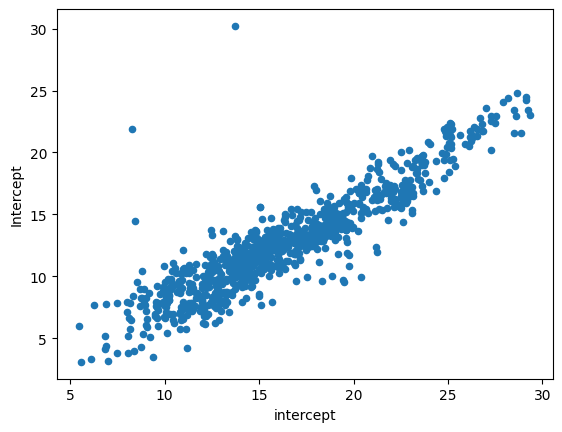

In [41]:
coefs[coefs["Intercept"] > 0].plot.scatter(x="intercept", y="Intercept")

## PCA

In [73]:
co_norm = (coefs - coefs.mean()) / coefs.std()
co_norm.iloc[:, :10]

,,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef
id,,,,,,,,,,,
01010000,0,-0.943126,1.020460,-0.239062,-1.207480,-1.574790,1.057523,1.185340,2.035952,-0.495313,0.335223
01011000,0,-0.874865,1.046572,-0.303112,-1.222831,-1.574790,-0.790702,1.723365,1.467359,-0.592296,0.137413
01018035,0,-0.762433,1.146347,-0.367163,-1.192130,-1.574790,-0.675188,1.043375,1.274206,-0.305630,0.431983
01038000,0,-0.379418,1.302420,-0.495264,-1.222831,0.691799,-1.021730,0.162987,0.618842,-0.218354,0.366795
010642505,0,-0.941962,0.135945,-0.367163,-1.253531,-1.482276,0.884252,0.976034,-0.397956,-0.516314,0.444743
...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,0,-1.170092,0.138135,-1.712223,0.619173,-0.510881,-0.963973,1.273442,0.014126,0.466665,-0.691027
394220106431500,0,-1.212328,-0.559231,-0.175011,0.527073,0.090459,1.115280,1.967705,0.632957,-0.344901,-0.445304
402114105350101,0,-1.769430,-0.565924,-1.648173,0.649873,-0.048312,1.115280,1.659354,-0.448210,0.022142,-0.365879


There are some nontrivial cross-correlations, so let's see what the principal component axes look like.  Let's limit it to stream properties (10 variables).

In [74]:
pca = PCA()
fit = pca.fit(co_norm.iloc[:, :10])
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.28635317 0.19484294 0.16747634 0.07725998 0.07444256 0.05951356
 0.0512307  0.0416597  0.03223543 0.01498563]
[0.28635317 0.48119611 0.64867245 0.72593242 0.80037498 0.85988854
 0.91111925 0.95277894 0.98501437 1.        ]


Compared to 10 coefficients, we can capture ~95% of the variance with 8 components.  6 components capture 86%.  Doesn't really seem worth pursuing.

<Axes: >

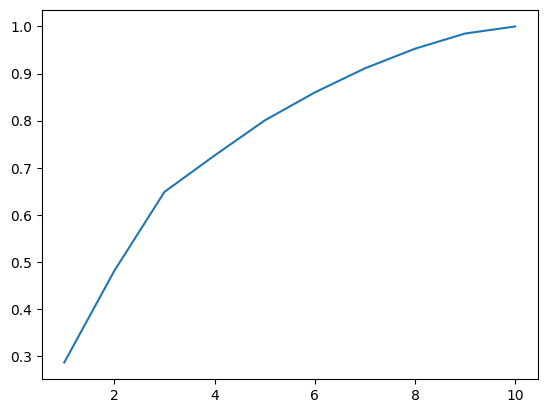

In [75]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

## Coefficient Correlations

### Geography

What's predictable from linear XYZ (plus squared longitude, which gives access to "coasts vs middle")?

In [98]:
coef_xyz = coefs.merge(data[["lat", "lon", "elev", "id"]].groupby("id").mean(), on="id").assign(lon2 = lambda x: (x["lon"] - x["lon"].mean())**2)
coef_xyz

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp,lat,lon,elev,lon2
id,,,,,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.275727,0.001378,8.787829,-6.067253,-15.167896,693.766616,-266.789732,-570.140506,46.700556,-69.715556,421.54080,575.889748
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.255334,0.001096,9.763696,-5.932321,-14.604735,699.838476,-263.185827,-560.410490,47.069722,-69.079444,362.70602,606.824801
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.315614,0.001516,11.344458,-5.606314,-14.288229,766.456060,-289.078520,-584.337550,46.181111,-67.803889,175.52219,671.295438
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.333966,0.001423,12.411499,-5.377854,-12.851322,880.149454,-319.869872,-646.207066,44.222778,-69.593889,109.47253,581.743994
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.271311,0.001534,10.084860,-5.104671,-12.878405,718.774950,-241.243771,-548.664202,44.083889,-71.285556,704.23030,503.001861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.478011,-0.000085,11.893447,-4.284127,-11.356781,574.381380,-190.504921,-319.363068,38.988361,-107.348489,2647.72120,185.919506
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.307356,0.000265,9.466164,-3.972916,-10.774711,516.589866,-135.047240,-276.552819,39.705000,-106.725833,3027.49410,169.327101
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.384537,0.000378,6.876817,-4.462743,-11.078878,476.261802,-147.476692,-304.520152,40.353861,-105.584139,3229.42850,140.917800


Intercept, Amplitude, SpringSummer, and air temperature variation are partially explained by XYZ, while mean air temperature and all of humidity are quite well explained.  Seasonality dates are very poorly explained.

In [99]:
coef_xyz.corr()[["lat", "lon", "elev", "lon2"]]**2

,lat,lon,elev,lon2
Intercept,0.434484,0.062616,0.170895,0.093716
Amplitude,0.000220,0.244220,0.061939,0.256083
FallDay,0.040251,0.000045,0.009747,0.024269
WinterDay,0.153067,0.048174,0.016780,0.087998
SpringDay,0.167345,0.007364,0.020012,0.022196
SummerDay,0.030443,0.001409,0.002904,0.000012
SpringSummer,0.178378,0.173442,0.234462,0.108312
FallWinter,0.002045,0.010155,0.021177,0.047704
at_coef,0.089587,0.057666,0.034808,0.094770
vp_coef,0.000768,0.028166,0.023897,0.002728


# General Additive Stationary Model

For preliminary prototyping, we'll use a GAM and see if we can pull some bits out later.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).  For now, we'll just make a "big model of all the variables", one at a time.

For the stationary model, weather summaries are predictors, not dependent variables.

A fundamental observation: it seems like improvements in the GAM are dominated by threshold behaviors, which is causing it to struggle to achieve good performance.  Possibly a different approach to prototyping would be in order.

## Generalized Code

In [11]:
data.columns

Index(['id', 'date', 'temperature', 'prcp', 'srad', 'swe', 'tmax', 'tmin',
       'vp', 'day', 'water', 'developed', 'barren', 'forest', 'shrubland',
       'herbaceous', 'cultivated', 'wetland', 'ice_snow', 'area', 'elev',
       'elev_min', 'elev_std', 'slope', 'asp', 'lat', 'lon'],
      dtype='object')

In [114]:
predictors = data.groupby("id", as_index=False)[["prcp", "srad", "water", "developed", "barren", "forest", "shrubland", "herbaceous", "cultivated", "wetland", "ice_snow", "area", "elev", "elev_min", "elev_std", "lat", "lon"]].mean().merge(
    data.groupby("id", as_index=False)[["prcp", "srad", "vp"]].std(),
    on="id", suffixes=["", "_sd"])
pmonthlies = data.assign(month = lambda x: x["date"].dt.month).groupby(["id", "month"])[["prcp", "srad", "tmax", "vp"]].mean().unstack(1)
pmonthlies.columns = [f"{x[0]}_{x[1]}" for x in pmonthlies.columns]
pds = coefs.drop(columns=["at_coef", "threshold_act_min", "coef_ratio"]).merge(predictors, on="id").dropna().\
    assign(tamp = lambda x: np.sqrt(x["ksin"]**2 + x["kcos"]**2))
pds["atmax"] = pds["intercept"] + pds["tamp"]
pds["atmin"] = pds["intercept"] - pds["tamp"]
pds = pds[pds["Intercept"] > 0]  # filter one erroneous site
# pds["vpmax"] = pds["intercept_vp"] + pds["hamp"]
# pds["vpmin"] = pds["intercept_vp"] - pds["hamp"]
Xpd = pds.iloc[:, 12:]
cols = Xpd.columns
Xall = Xpd.to_numpy()
Xmo = pds.merge(pmonthlies, on="id").dropna()
Xpdmo = Xmo.loc[:, 'intercept':]

In [116]:
# Reference linear model
X = np.concatenate((np.ones((len(Xpd), 1)), Xpd.to_numpy()), axis=1)
# y = pds.iloc[:, 1:12]
y = pds.iloc[:, 1:12]
fit = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ fit
pd.concat([
    pd.DataFrame({"R2": np.corrcoef(y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[y.columns[i]])
    for i in range(len(y.columns))
])

,R2
Intercept,0.866532
Amplitude,0.552846
FallDay,0.236674
WinterDay,0.372651
SpringDay,0.270303
SummerDay,0.202520
SpringSummer,0.483586
FallWinter,0.322211
threshold_coef_min,0.058279
threshold_act_cutoff,0.109123


So, that one site (one site!) with a very negative Intercept was seriously screwing things up.  Linear R2 for Intercept is now 0.88, roughly as expected.  That holds similarly if we exclude the monthly data.

Naive GAM performance comparison:

- Intercept: outperforms linear with r2 = 0.8
- Amplitude: marginally outperforms linear with r2 = 0.64
- SpringSummer: marginally outperforms linear with r2 = 0.57
- FallWinter: outperforms linear with r2 = 0.56
- SpringDay: barely outperforms linear with r2 = 0.48
- SummerDay: outperforms linear with r2 = 0.40
- FallDay: outperforms linear with r2 = 0.42
- WinterDay: marginally outperforms linear with r2 = 0.51
- at_coef: dramatically outperforms linear with r2 = 0.68
- vp_coef: dramatically outperforms linear with r2 = 0.76

In [121]:
def scatterplots(yv, data=pds, skip=12):
    xv = data.columns[skip:]
    nt = len(xv)
    Ny = 4
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    fig, axes = plt.subplots(Ny, Nx, figsize=(12,10))
    fig.tight_layout()
    for i, term in enumerate(xv):
        ax = axes[i // Nx, i % Nx]
        data.plot.scatter(x=term, y=yv, ax=ax)

def focused_scatters(yv, xv, data=pds):
    sns.pairplot(data, vars=xv+[yv])

l = 10
def build_eq(n, latlon):
    base = te(0, 1, lam=0.1) if latlon else s(0, lam=l)
    for i in range(2 if latlon else 1, n):
        base += s(i, lam=l)
    return base

def runit(x, y, latlon, keep=[], previous=None, previous_r2=None, threshold=0.02):
    if latlon and keep == []:
        keep = ["lat", "lon"]
    builder = lambda col: LinearGAM(build_eq(len(keep) + 1, latlon), lam=l).fit(x[keep + [col]], y)
    fits = pd.concat([
        pd.DataFrame({"r2": stat["pseudo_r2"]["explained_deviance"], "GCV": stat["GCV"], "AIC": stat["AIC"]}, index=[col])
        for col in x.columns
        for stat in [builder(col).statistics_]
        if not col in keep
    ]).sort_values("r2", ascending=False)
    best = fits[fits["r2"] == fits["r2"].max()].iloc[0]
    vr = best.name
    [r2, gcv, aic] = best
    delta = r2 - previous_r2 if previous_r2 is not None else 0
    df = pd.DataFrame({"r2": r2, "gcv": gcv, "aic": aic, "delta_r2": delta}, index=[vr])
    if previous is not None:
        df = pd.concat([previous, df])
    if previous_r2 is not None and delta < threshold:
        best_gam = builder(vr)
        print(df.sort_values("r2", ascending=False))
        return best_gam
    else:
        print(f"Added {vr} with delta {delta: .3f}")
        return runit(x, y, latlon, keep + [vr], df, r2, threshold)

def pdps(gam, xy0=True):
    nt = len(gam.terms)
    Ny = 2 if nt < 9 else 3
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(repr(term))



## Intercept

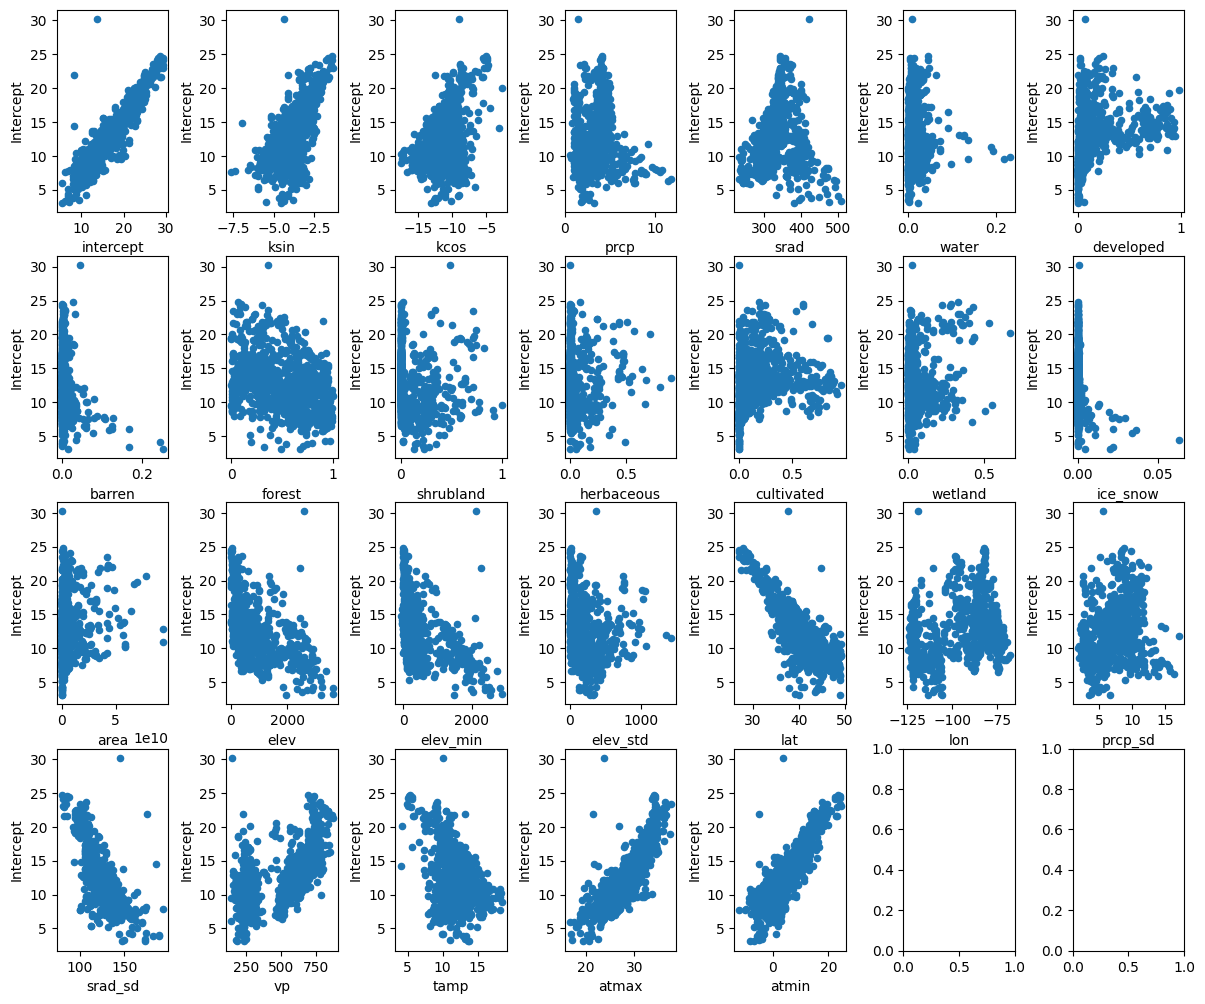

In [122]:
scatterplots("Intercept")

Relationship notes:

- The wetland effect appears to stand alone. It only correlates with other land covers, which it has to - though the effect is not strong.
- The elevation effect is identical to the relationship elevation has with mean air temperature.  Ignore elevation.
- Mean air temperature and latitude correlate very well, and it looks like that probably dominates the latitude effect.
- Vapor pressure has an interesting, and surprising, mapping to srad_sd, which seems to mirror its relationship to mean temperature.
- Latitude's effect is captured in mean air temperature.
- srad_sd seems to map well to mean air temperature, as a proxy for latitude.  Not worthwhile standalone.
- tamp, likewise.
- Developed, likewise.

Basically, all weather variables (and latitude) are correlating as proxies for mean air temperature.  However, forest and wetland have standalone effects - though the effect of wetlands disappears on closer inspection.  Basically, mean air temperature and forest pretty much do the job - in a roughly linear fashion.

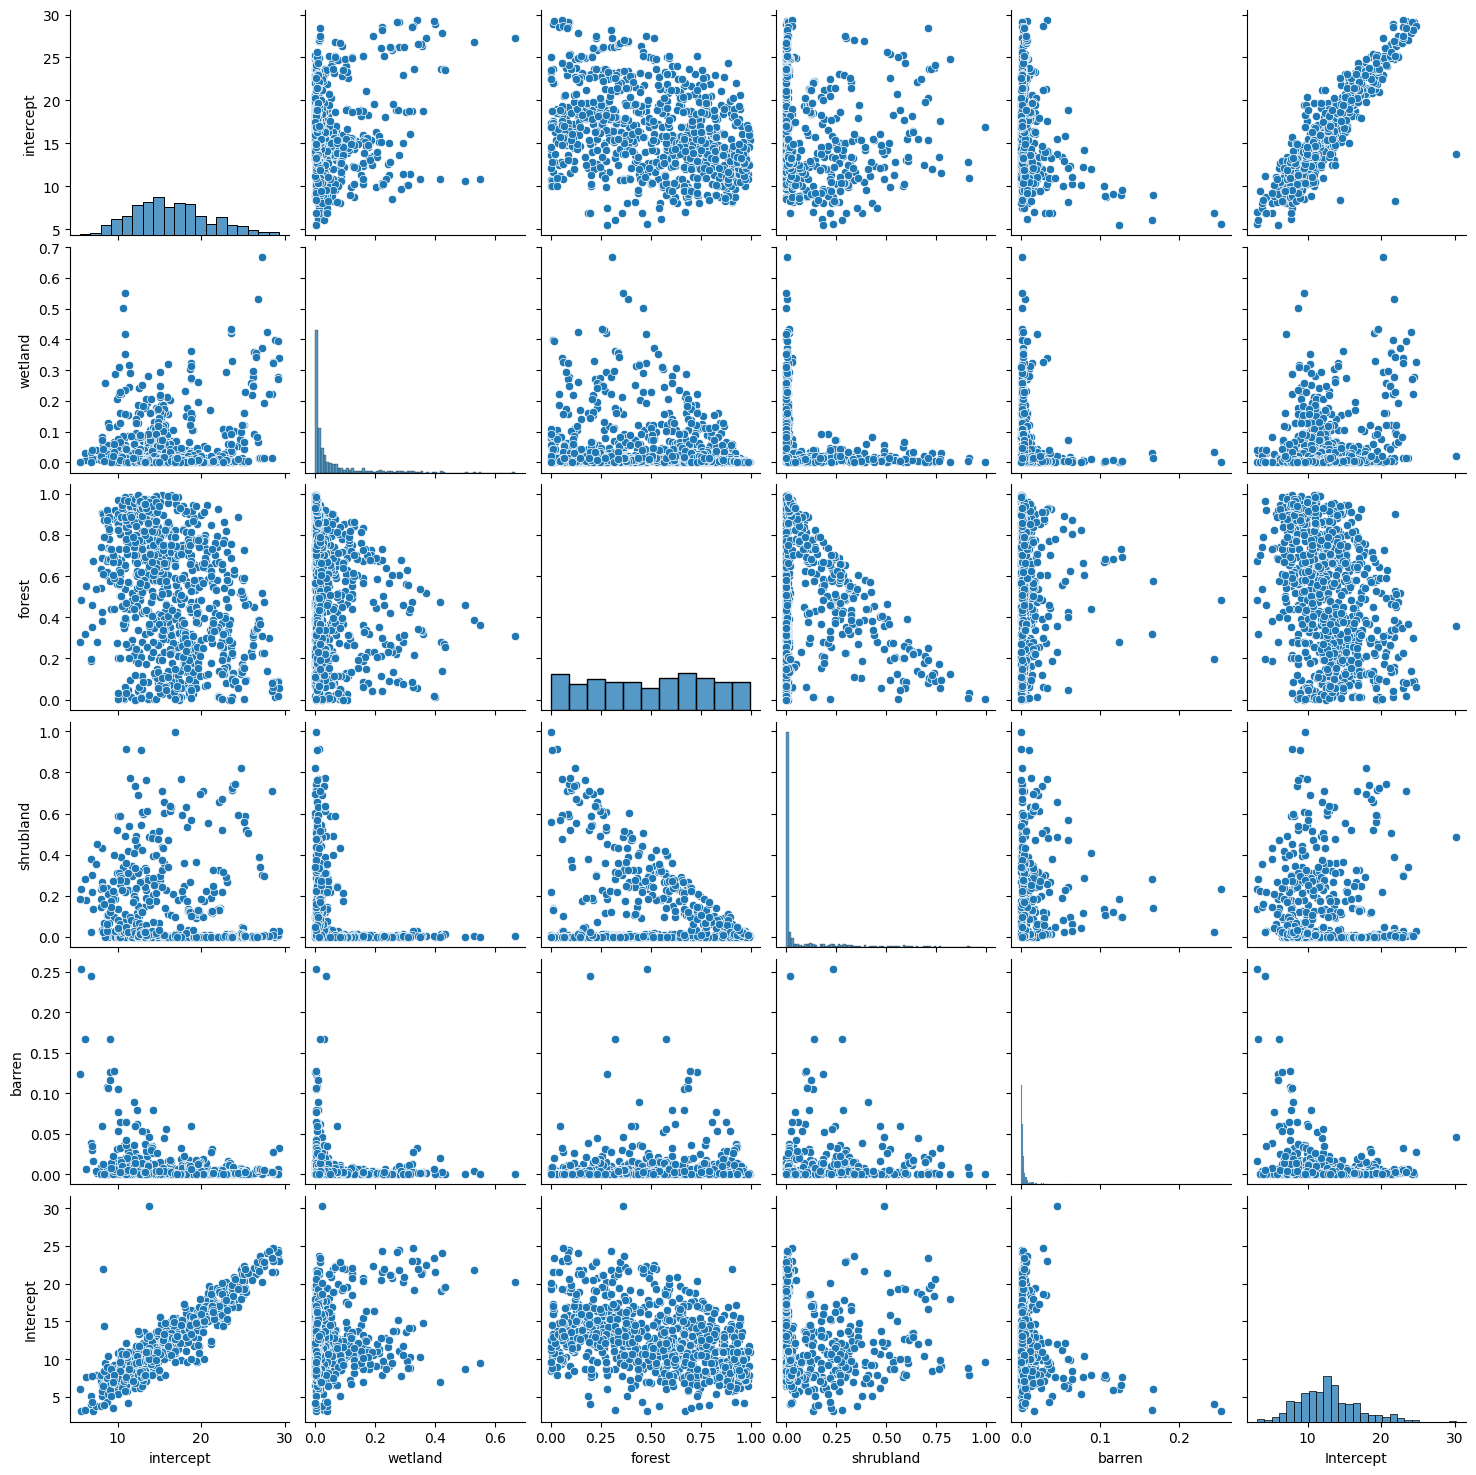

In [125]:
focused_scatters("Intercept", ["intercept", "wetland", "forest", "shrubland", "barren"])

In [135]:
LinearGAM(te(0, 1)).fit(pds[["intercept", "forest"]], pds["Intercept"]).summary()  # doesn't do any better.

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.1991
Link Function:                     IdentityLink Log Likelihood:                                 -1848.7178
Number of Samples:                          922 AIC:                                             3741.8338
                                                AICc:                                            3742.9798
                                                GCV:                                                 2.526
                                                Scale:                                              2.4217
                                                Pseudo R-Squared:                                   0.8512
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_24476\299183742.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  LinearGAM(te(0, 1)).fit(pds[["intercept", "forest"]], pds["Intercept"]).summary()  # doesn't do any better.


## Amplitude

Here, we have more work to do, as a linear model only captures 55-60% of variance.

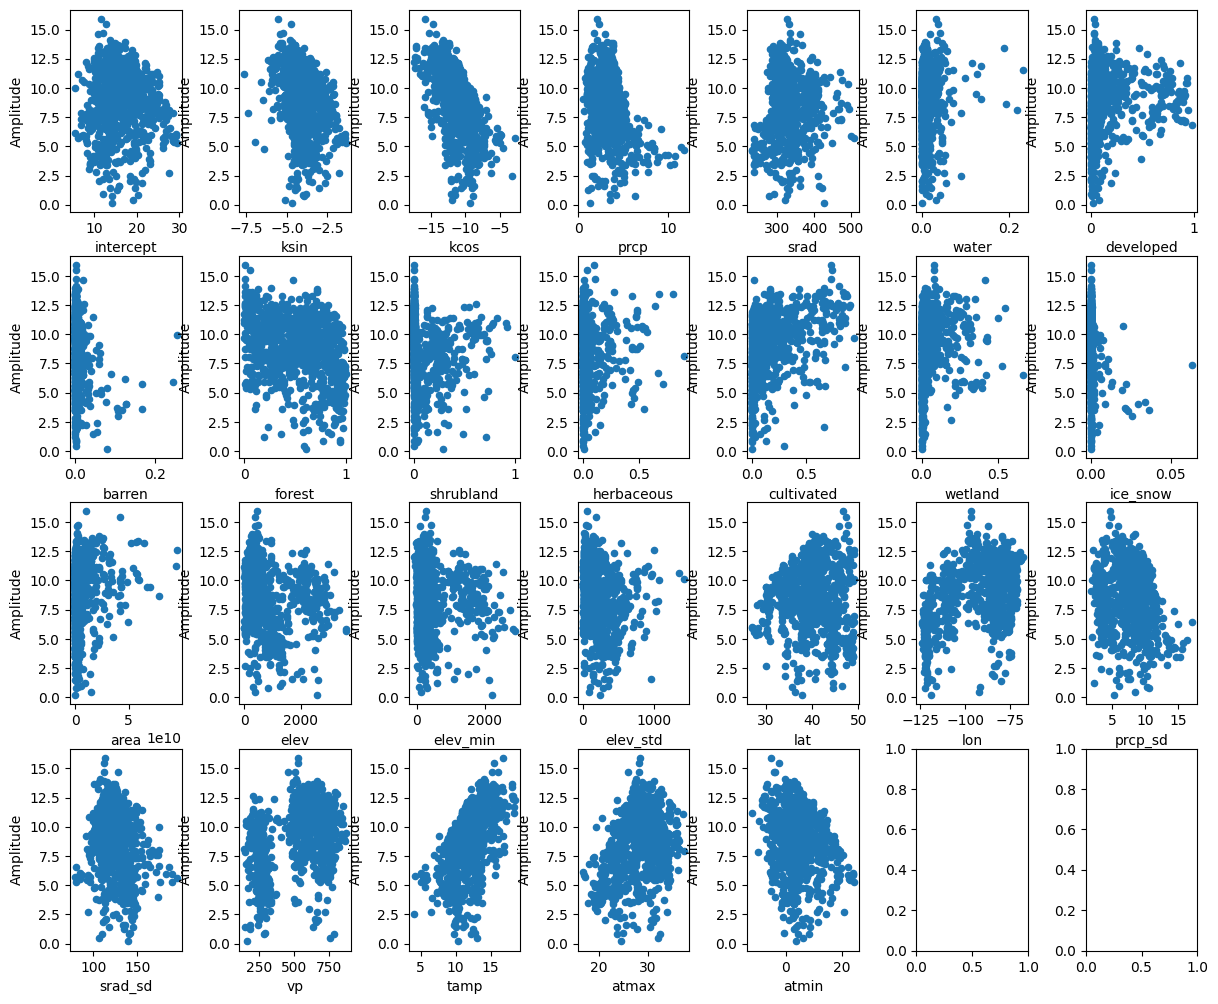

In [133]:
scatterplots("Amplitude")

- intercept is not relevant
- tamp is a major predictor.  Interestingly, it has a strong, negative relationship with prcp_sd.
- prcp and prcp_sd correlate very strongly.  prcp itself has a weaker effect.
- forest has some, very noisy, effect, but it looks like an exact mirror of its relationship to prcp_sd.
- cultivated definitely has its own thing going on, and a nonzero effect.
- Developed has some threshold behavior, but little effect otherwise.  (Sites at a certain development level always have a higher amplitude.)
- prcp_sd has no effect except through tamp.
- The air temperature amplitude variables seem to be somewhat interchangeable.  tamp or kcos are the best candidates.

It looks like we want cultivated, developed, and tamp.

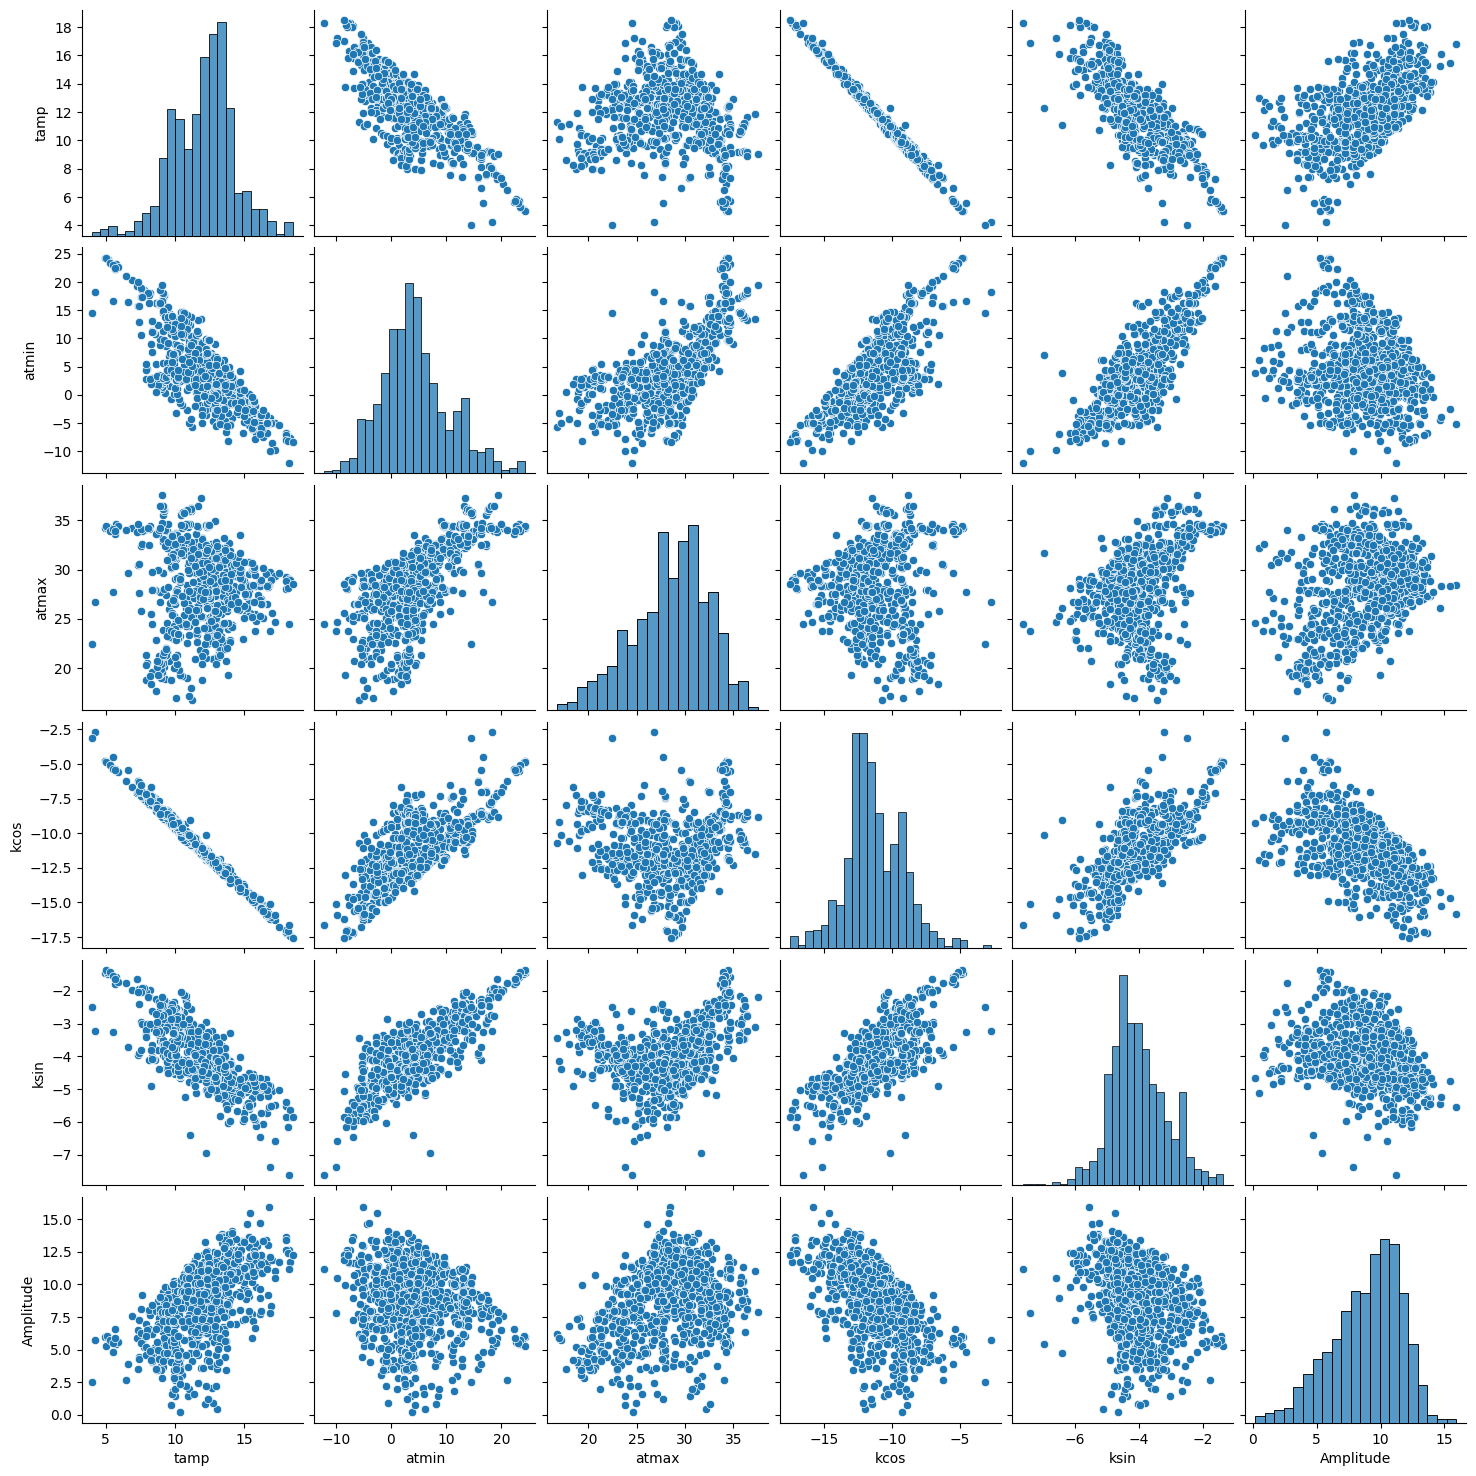

In [138]:
focused_scatters("Amplitude", ["tamp", "atmin", "atmax", "kcos", "ksin"])

In [140]:
gam_amp = LinearGAM(s(0) + s(1) + s(2)).fit(pds[["tamp", "cultivated", "developed"]], pds["Amplitude"])
gam_amp.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     35.6052
Link Function:                     IdentityLink Log Likelihood:                                 -2189.7551
Number of Samples:                          922 AIC:                                             4452.7206
                                                AICc:                                            4455.8336
                                                GCV:                                                4.0575
                                                Scale:                                              3.7764
                                                Pseudo R-Squared:                                   0.5106
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_24476\455630513.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_amp.summary()


Optimal GAM (r2 0.65) has wetland, vapor pressure cosine coefficient, and min elevation.

- Amplitude is largest in the south.
- Amplitude decreases in a somewhat stepwise, inconsistent fashion with increasing min elevation. A decent approximation would be constant up to 1200 m, then linear at about 3 C per km.
- Vapor pressure amplitude has a noisily logarithmic relationship.
- Wetland abundance also seems noisily logarithmic.

Performance is a bit worse with PCA (r2 0.59).

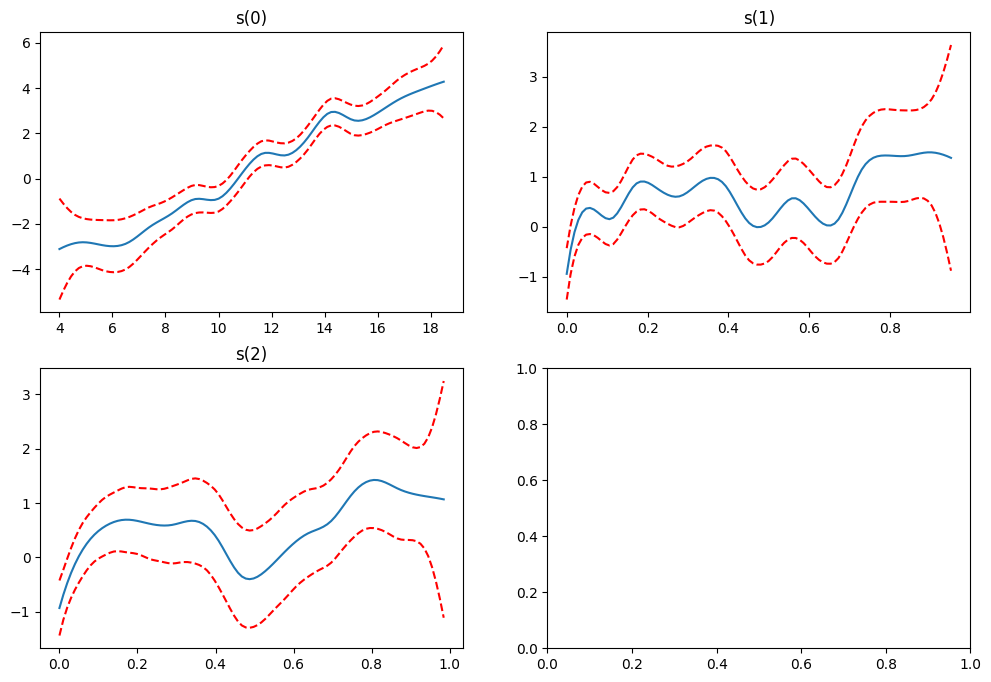

In [142]:
pdps(gam_amp, False)

## SpringSummer

In [406]:
gam_ssu = runit(xpca, Xmo["SpringSummer"].to_numpy())

Added ax0 with delta  0.000
Added ax2 with delta  0.047
Added ax6 with delta  0.034
Added ax4 with delta  0.025
Added ax1 with delta  0.026
           r2       gcv          aic  delta_r2
ax7  0.509092  0.704769  2162.513227  0.015731
ax1  0.493360  0.705060  2168.037789  0.025604
ax4  0.467757  0.713533  2179.689592  0.024871
ax6  0.442886  0.720289  2190.275281  0.033866
ax2  0.409020  0.735792  2207.397787  0.047490
ax0  0.361529  0.763571  2234.824867  0.000000


Optimal GAM (r2 0.57) has wetland, June precip, and tmax 1, 2, 6.

- Once again, a strong north-south gradient in space.
- June air temperature has a powerful negative (linearish) relationship.
- February air temperature does a down-then-up thing.
- January air temperature is the reverse of February, so I suspect there's a combined winter effect that does less.
- June precipitation is linear-constant-linear (increasing) with breaks at 3 and 6 mm/day.
- Wetland relationship looks like noise.

Performance is worse with PCA, max r2 0.51.

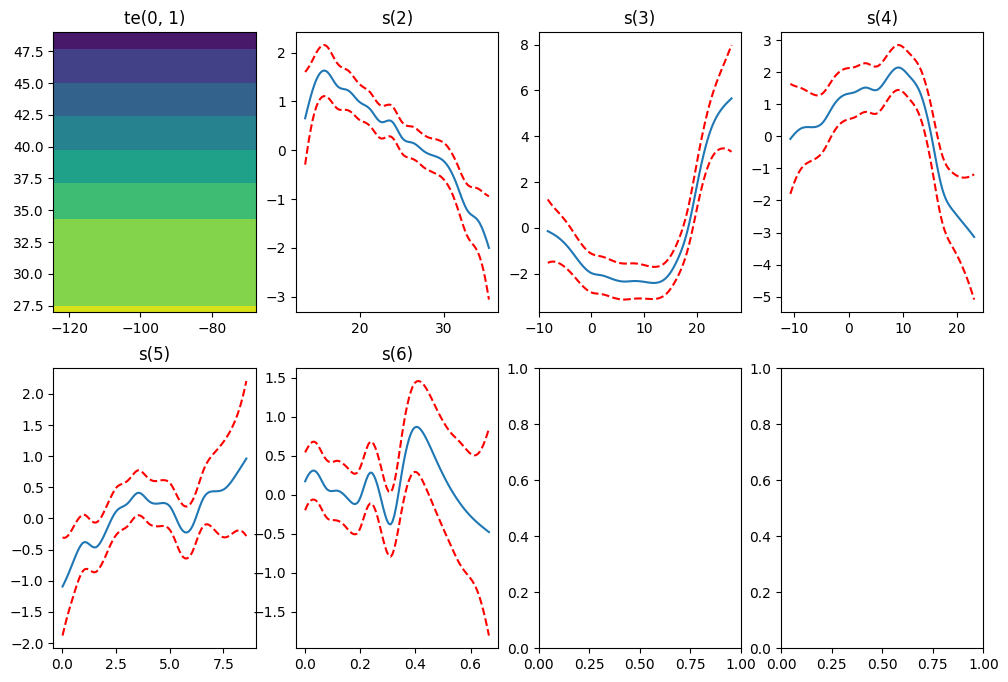

In [341]:
pdps(gam_ssu)

## FallWinter

In [317]:
gam_fw = runit(Xmo["FallWinter"].to_numpy())

Added tmax_3 with delta  0.053
Added water with delta  0.036
Added wetland with delta  0.039
Added srad_8 with delta  0.027
Added srad_4 with delta  0.023
                r2       gcv          aic  delta_r2
elev_min  0.555605  0.483374  2112.707838  0.017697
srad_4    0.537908  0.483826  2112.011972  0.023345
srad_8    0.514563  0.489234  2109.661999  0.027314
wetland   0.487249  0.496695  2107.601839  0.039458
water     0.447791  0.518125  2105.367293  0.036210
tmax_3    0.411581  0.536793  2107.018723  0.052612


Optimal GAM (r2 0.56) has elev_min, srad_4,8, wetland, water, and tmax_3.

- I'm wondering if there's a bug with the north-south thing or if east-west is just reliably captured elsewhere.
- March air temperature is more or less linear (increasing) after 10 C.
- Water abundance has a strong decline until 0.02 or so, then noise.  Looking at square-root-abundance could be useful.
- Wetlands have a logarithmic response.
- August sunshine looks like noise/overfitting.
- April sun, on the other hand, has a big threshold effect around 550 W/m2.
- Elevation looks noisy, possibly with a decreasing linear term (that's the wrong direction).

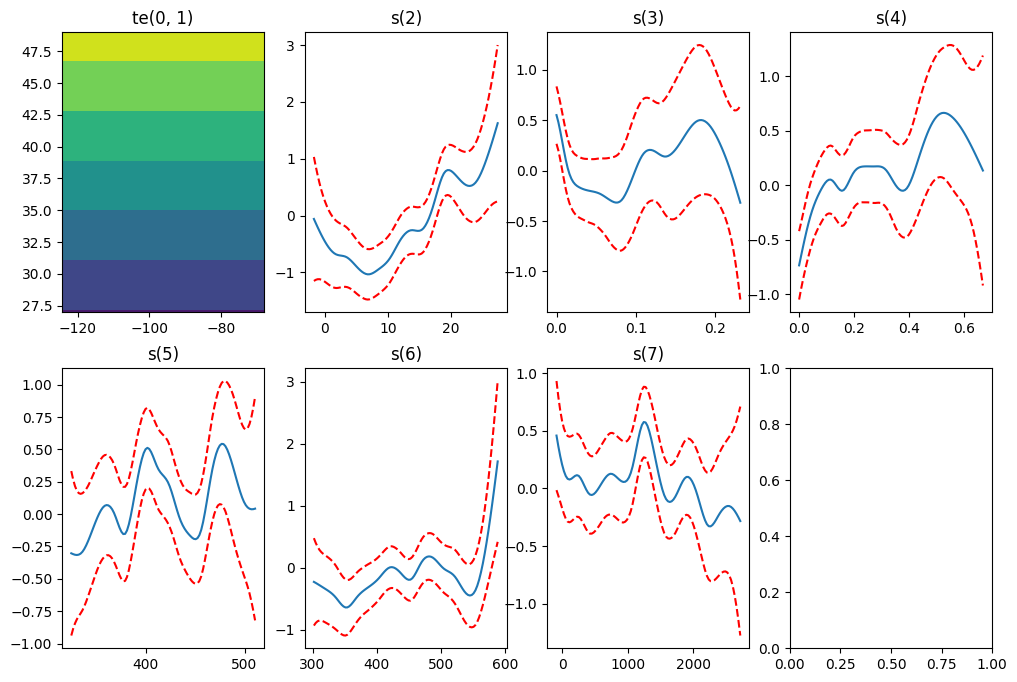

In [342]:
pdps(gam_fw)

## SpringDay

In [318]:
gam_spd = runit(Xmo["SpringDay"].to_numpy())

Added tmax_4 with delta  0.047
Added tmax_3 with delta  0.062
Added elev_std with delta  0.028
                r2         gcv           aic  delta_r2
prcp_4    0.476807  319.249036  11361.534502  0.017445
elev_std  0.459362  317.783316  11375.093434  0.027686
tmax_3    0.431676  322.915473  11421.582221  0.061805
tmax_4    0.369871  345.386252  11556.662346  0.046942


Optimal GAM (r2 0.48) has prcp_4, elev_Std, tmax_3 and 4.  Side comment: we should expect logistic relationships for dates, since they have a fixed range.

- North-south
- Strong linear trend with April air temperature between 10 and 25 C, otherwise constant (~logistic)
- Logistic negative trend with March air temperature between about 5 and 20 C.  Note pretty good offset between March/April, probably a mean.
- Sort of steppish decline (earlier) with elevation, could be modeled by exponential decay (~constant by ~800 m).
- Threshold response to April precip (up to 2 mm/day), then constant.

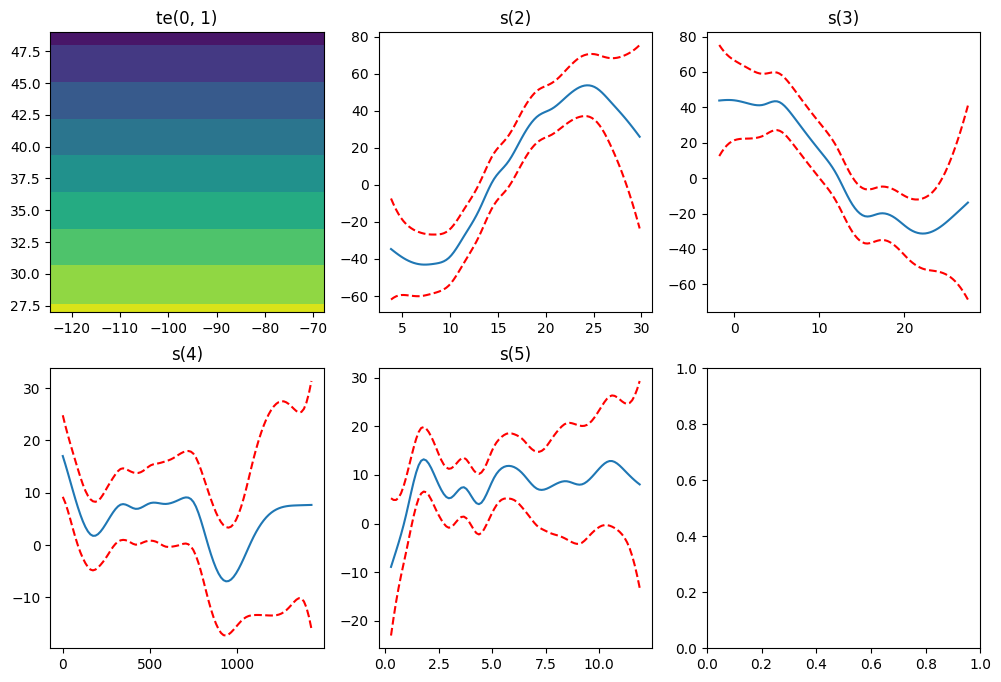

In [343]:
pdps(gam_spd)

## SummerDay

In [319]:
gam_sud = runit(Xmo["SummerDay"].to_numpy())

Added tmax_7 with delta  0.048
Added tmax_9 with delta  0.040
Added elev_std with delta  0.030
Added cultivated with delta  0.028
Added tmax_8 with delta  0.023
Added vp_5 with delta  0.023
                  r2         gcv           aic  delta_r2
water       0.396410  255.662999  10912.606713  0.019499
vp_5        0.376911  256.068889  10933.913449  0.022750
tmax_8      0.354161  254.982914  10950.808314  0.022965
cultivated  0.331195  254.905904  10971.060971  0.027754
elev_std    0.303442  254.832246  10994.132292  0.030231
tmax_9      0.273210  257.020990  11027.857785  0.040151
tmax_7      0.233059  260.976130  11075.152029  0.047889


Optimal GAM (r2 0.40) has water, vp_5, tmax_8,9,7, cultivated, and elev_std.

- North-south
- Solid linear drop (or logisticish) with July temperatures
- Reverse pattern with September and August temperatures; consider summer mean
- Noisy elevation response, could be logarithmic or constant
- Constant with cultivated, that's noise
- vp looks like noise
- Water looks like noise, maybe a slight increase.  Try linear.

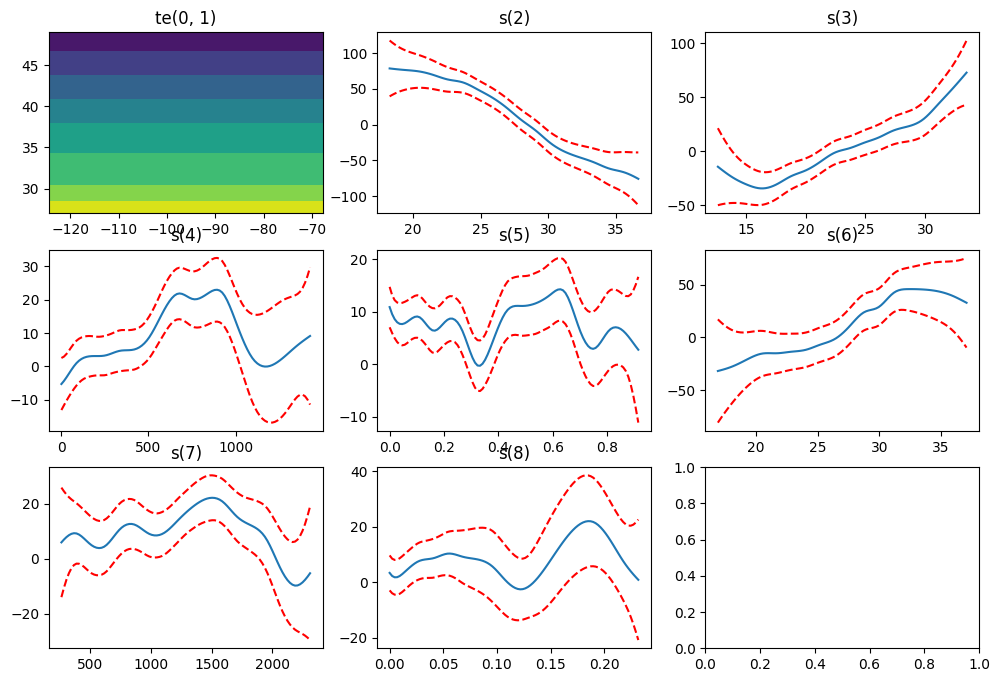

In [344]:
pdps(gam_sud)

## FallDay

In [320]:
gam_fd = runit(Xmo["FallDay"].to_numpy())

Added water with delta  0.087
Added srad_4 with delta  0.033
Added elev with delta  0.027
Added tmax_2 with delta  0.027
Added tmax_12 with delta  0.023
               r2         gcv           aic  delta_r2
srad_1   0.419340  181.790446  10354.914121  0.019170
tmax_12  0.400171  181.092620  10370.060946  0.022794
tmax_2   0.377376  181.157864  10392.291498  0.027498
elev     0.349879  182.168469  10423.343100  0.026612
srad_4   0.323267  182.458527  10447.549775  0.033108
water    0.290159  184.322369  10485.392092  0.086969


Optimal GAM (r2 0.42) has srad_1, 4, tmax_2, 12, elev, and water.

- North-south
- Logarithmic response with water
- Solid negative linear with April solar radiation
- Linearish with elevation; big drop at 3000 m, but too few up there to be sure
- Solid positive linear with February air temperature
- Negative response to December air, not quite canceling out - consider winter air temp
- Logarithmic response with January solar radiation

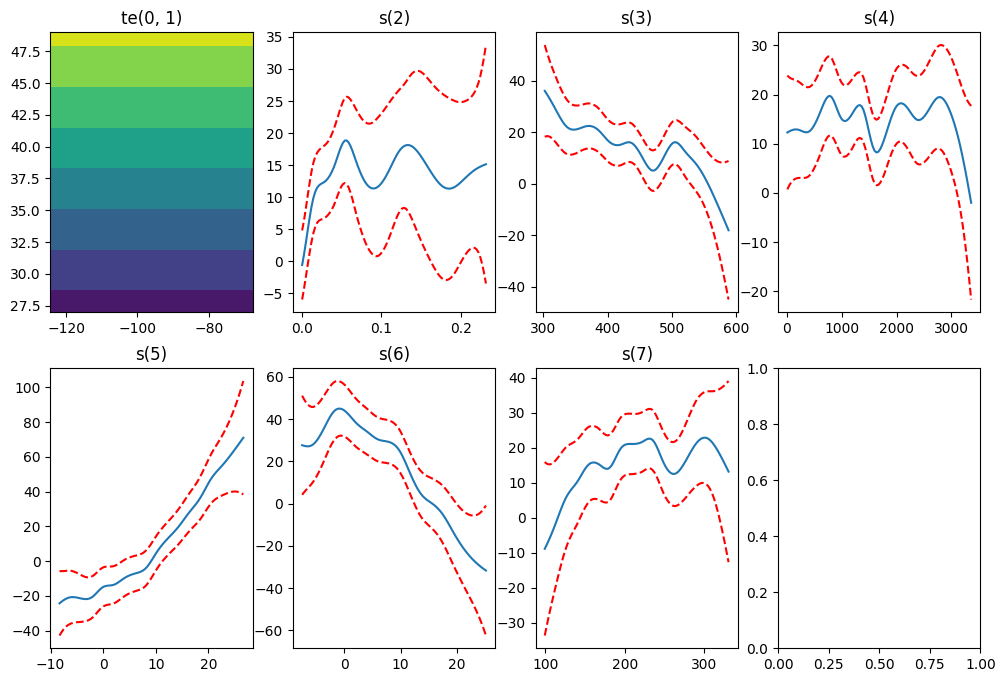

In [345]:
pdps(gam_fd)

## WinterDay

In [321]:
gam_wd = runit(Xmo["WinterDay"].to_numpy())

Added intercept_tm with delta  0.089
Added elev_std with delta  0.028
Added prcp_2 with delta  0.023
                    r2         gcv           aic  delta_r2
srad_10       0.506934  677.018594  12650.897800  0.015470
prcp_2        0.491463  671.712426  12659.645398  0.023359
elev_std      0.468104  677.440885  12694.627880  0.028354
intercept_tm  0.439750  690.092490  12744.688157  0.088929


Optimal GAM (r2 0.51) has srad_10, prcp_2, elev_std, and intercept_tm.

- North-south
- Logarithmic with mean tmax
- Noisy with elevation, looks like it's fitting random spots.  Maybe linear/logistic is worth a shot.
- Noisy-constant with precip
- Noisy-constant with srad.

Summary: spatial and tmax-mean pretty much cover it.

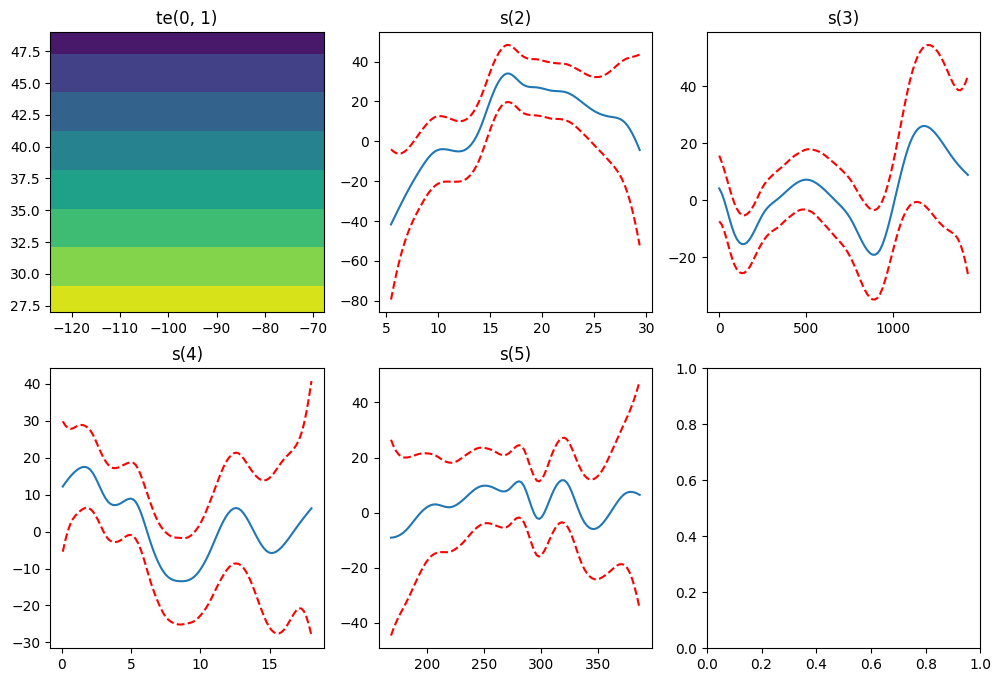

In [346]:
pdps(gam_wd)

## Tmax

In [322]:
gam_at = runit(Xmo["at_coef"].to_numpy())

Added vp_4 with delta  0.072
Added intercept_vp with delta  0.121
Added vp_12 with delta  0.055
Added vp_3 with delta  0.050
Added vp_2 with delta  0.047
Added ksin_tm with delta  0.040
Added forest with delta  0.021
Added water with delta  0.023
                    r2       gcv           aic  delta_r2
area          0.676189  0.021413  40239.574841  0.017174
water         0.659015  0.021821  38966.282436  0.022541
forest        0.636473  0.022567  37163.438814  0.020924
ksin_tm       0.615549  0.022772  36203.595385  0.040208
vp_2          0.575342  0.024224  33399.718866  0.046544
vp_3          0.528798  0.026067  30492.607014  0.050454
vp_12         0.478344  0.027909  27960.883955  0.054588
intercept_vp  0.423756  0.029846  25677.054547  0.120631
vp_4          0.303125  0.034867  21344.038544  0.071955


Optimal GAM (r2 0.68) has area, water, forest, ksin_tm, intercept_vp, and vp_2,3,4,12.

- North-south
- Bunch of opposing thresholds to the five VPs, consider some sort of mean.
- Threshold response to air-T sine amplitude
- Noisy decline with forested area, looks like constant to 0.3 then linear
- Noisy decrease-then-increase with water, not sure how to model that
- Noisy increase with area

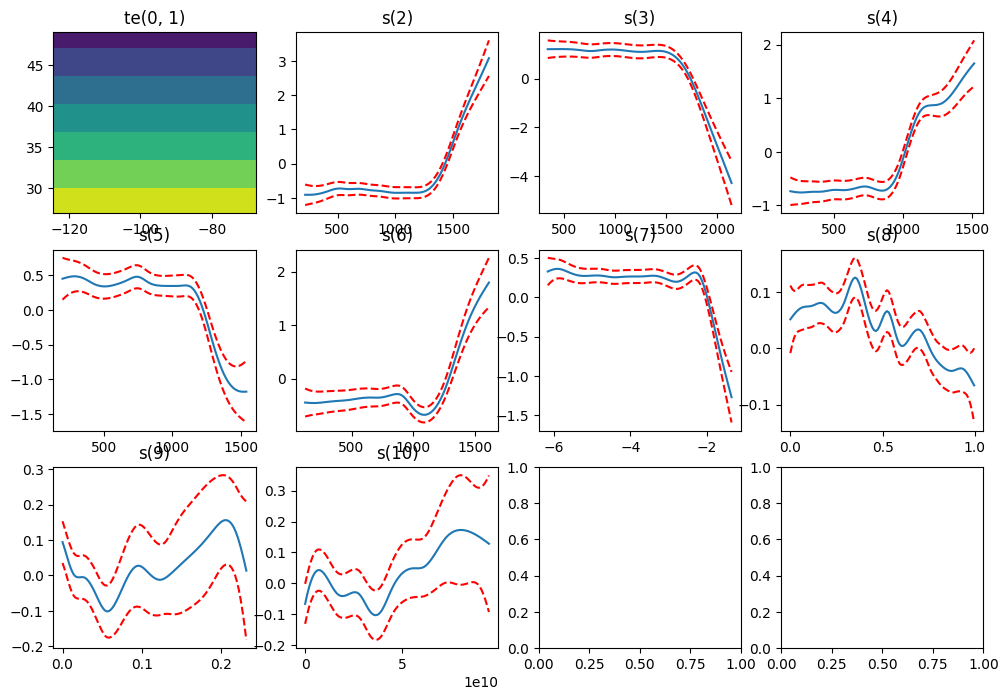

In [347]:
pdps(gam_at)

## vp

In [323]:
gam_vp = runit(Xmo["vp_coef"].to_numpy())

Added tmax_2 with delta  0.095
Added tmax_12 with delta  0.126
Added vp_11 with delta  0.116
Added vp_4 with delta  0.061
Added vp_3 with delta  0.076
Added vp_2 with delta  0.062
Added srad_12 with delta  0.025
Added vp_12 with delta  0.023
Added ksin_tm with delta  0.026
Added vp_5 with delta  0.022
               r2           gcv           aic  delta_r2
srad_10  0.761786  8.234137e-07  1.209963e+09  0.014691
vp_5     0.747095  8.393964e-07  1.170906e+09  0.021617
ksin_tm  0.725478  8.797700e-07  1.104315e+09  0.026375
vp_12    0.699103  9.283521e-07  1.033633e+09  0.022921
srad_12  0.676182  9.710610e-07  9.791469e+08  0.025408
vp_2     0.650775  1.006953e-06  9.325001e+08  0.061557
vp_3     0.589218  1.150633e-06  8.086386e+08  0.076180
vp_4     0.513038  1.318135e-06  6.983856e+08  0.061102
vp_11    0.451936  1.430999e-06  6.361961e+08  0.115758
tmax_12  0.336178  1.681096e-06  5.365306e+08  0.126170
tmax_2   0.210007  1.930193e-06  4.622729e+08  0.095128


Optimal GAM (r2 0.76) has srad_10,12, vp_2,3,4,5,12, tmax_2,12, and ksin_tm.  It's all weather, basically.

- North-south
- Linearish with February air
- Threshold response with December air
- Thresholds with November-Dec and Feb-May humidity, use winter-spring mean
- Noisy srad response
- Threshold response to ksin-air
- Noisy decline with October srad

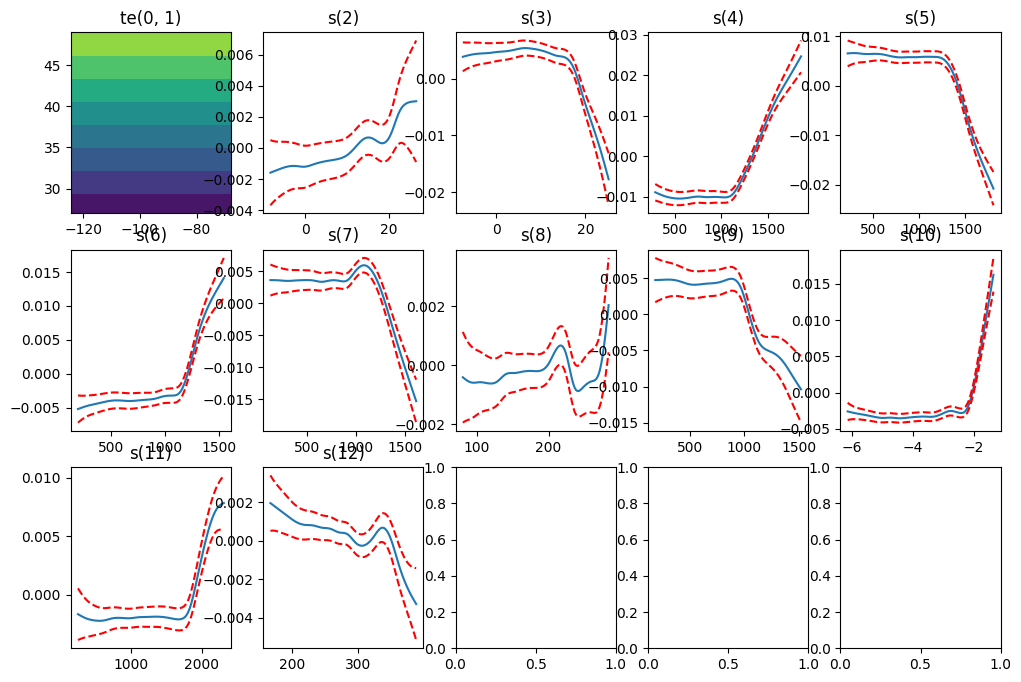

In [348]:
pdps(gam_vp)

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  In general, naive GAMs solidly outperform the linear models, so we'll start with those.

## Naive GAMs

In [2]:
itx_var = ["lat", "lon", "tmax_3", "tmax_4", "tmax_12", "vp_2", "vp_11", "vp_12"]
amp_var = ["lat", "lon", "wetland", "kcos_vp", "elev_min"]
ssu_var = ["lat", "lon", "wetland", "prcp_6", "tmax_1", "tmax_2", "tmax_6"]
fw_var = ["lat", "lon", "elev_min", "srad_4", "srad_8", "wetland", "water", "tmax_3"]
spd_var = ["lat", "lon", "prcp_4", "elev_std", "tmax_3", "tmax_4"]
sud_var = ["lat", "lon", "water", "vp_5", "tmax_8", "cultivated", "elev_std", "tmax_9", "tmax_7"]
fad_var = ["lat", "lon", "srad_1", "tmax_12", "tmax_2", "elev", "srad_4", "water"]
wid_var = ["lat", "lon", "srad_10", "prcp_2", "elev_std", "intercept_tm"]
at_var = ["lat", "lon", "area", "water", "forest", "ksin_tm", "vp_2", "vp_3", "vp_12", "intercept_vp", "vp_4"]
vp_var = ["lat", "lon", "srad_10", "vp_5", "ksin_tm", "vp_12", "srad_12", "vp_2", "vp_3", "vp_4", "vp_11", "tmax_12", "tmax_2"]
shared = list(set(itx_var + amp_var + ssu_var + fw_var + spd_var + sud_var + fad_var + wid_var + at_var + vp_var))
names = ["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay", "SummerDay", "FallDay", "WinterDay", "at_coef", "vp_coef"]

In [3]:
# gam_data = data[["id", "date", "temperature", "vp", "tmax"]].merge(Xmo, on="id")
# gam_data.to_csv("MergedData.csv")
gam_data = pd.read_csv("MergedData.csv", dtype={"id": "str"})
gam_data["date"] = pd.to_datetime(gam_data["date"])
gam_data["day"] = gam_data["date"].dt.day_of_year

In [6]:
cd = gam_data.groupby("id")[shared + names].mean()
g = LinearGAM(build_eq(len(itx_var), True)).fit(cd[itx_var], cd["Intercept"].to_numpy())
g.predict(cd[itx_var])[0]

9.15492775691442

In [13]:
wst = gam_data[gam_data["id"] == gam_data["id"].iloc[0]]
wst[shared].mean().to_frame().T

,prcp_6,vp_3,tmax_12,srad_1,lon,tmax_1,tmax_3,srad_4,tmax_9,tmax_8,...,wetland,cultivated,water,tmax_2,elev_std,vp_4,tmax_7,tmax_6,vp_11,prcp_2
0,1.063464,275.2133,-4.053537,254.91296,-110.178722,-2.779675,3.363886,515.61234,16.454326,20.382895,...,0.04023,0.0,0.000756,-3.85792,130.430969,336.044278,21.702253,16.458075,284.830735,3.405588


In [17]:
def gam_modbuilder(data):
    print("preparing data")
    cd = data.groupby("id")[shared + names].mean()
    builder = lambda cols, yn: LinearGAM(build_eq(len(cols), True)).fit(cd[cols], cd[yn].to_numpy())
    predictor = lambda cols, gam, ws: gam.predict(ws[cols])[0]
    print("Training models")
    gam_itx = builder(itx_var, "Intercept")
    gam_amp = builder(amp_var, "Amplitude")
    gam_ssu = builder(ssu_var, "SpringSummer")
    gam_fw = builder(fw_var, "FallWinter")
    gam_spd = builder(spd_var, "SpringDay")
    gam_sud = builder(sud_var, "SummerDay")
    gam_fad = builder(fad_var, "FallDay")
    gam_wid = builder(wid_var, "WinterDay")
    gam_at = builder(at_var, "at_coef")
    gam_vp = builder(vp_var, "vp_coef")
    print("Trained models")
    def runner(ws):
        # print(f"Running {ws['id'].iloc[0]}")
        # try:
        at_day = ws.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        vp_day = ws.groupby(["day"], as_index=False)["vp"].mean().rename(columns={"vp": "mean_vp"})
        statics = ws[shared].mean().to_frame().T
        model = Watershed(seasonality=rts.ThreeSine(
            Intercept=predictor(itx_var, gam_itx, statics),
            Amplitude=predictor(amp_var, gam_amp, statics),
            SpringSummer=predictor(ssu_var, gam_ssu, statics),
            FallWinter=predictor(fw_var, gam_fw, statics),
            SpringDay=predictor(spd_var, gam_spd, statics),
            SummerDay=predictor(sud_var, gam_sud, statics),
            FallDay=predictor(fad_var, gam_fad, statics),
            WinterDay=predictor(wid_var, gam_wid, statics)
        ),
                          at_coef=predictor(at_var, gam_at, statics),
                          vp_coef=predictor(vp_var, gam_vp, statics),
                          at_day=at_day,
                          vp_day=vp_day)
        return model.run_series(ws)
        # except Exception as e:
        #     print(e)
    return runner

In [18]:
kfr = kfold(gam_data, gam_modbuilder, output="results/NaiveGAM.csv")

preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models


/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: invalid value encountered in sin
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: invalid value encountered in sin
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \


preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models


In [20]:
perf_summary(kfr)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.694139,4.719429,0.692002,2.082688,0.268983,5.390829


In [22]:
kfr.groupby("id").apply(perf_summary, include_groups=False).median()

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


R2         0.944026
RMSE       2.218157
NSE        0.893316
Pbias      2.413418
Bias       0.308628
MaxMiss    2.774715
dtype: float64

In [34]:
rng = np.random.default_rng()
ids = rng.choice(kfr["id"].unique(), 8)

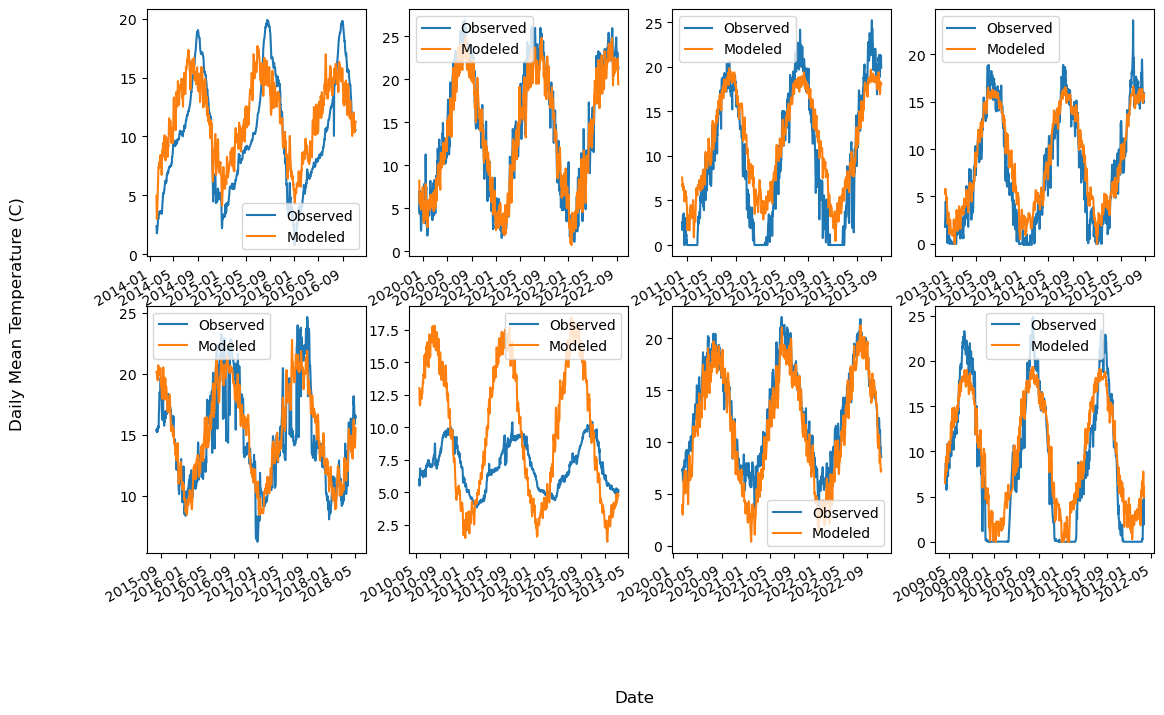

In [39]:
Ny = 2
Nx = 4
fig, axes = plt.subplots(Ny, Nx, figsize=(13, 8))
for i, ID in enumerate(ids):
    ax = axes[i // Nx, i % Nx]
    dat = kfr[kfr["id"] == ID]
    if len(dat) > 1100:
        start = rng.integers(0, len(dat) - 1000)
        dat = dat.iloc[start:(start + 1000), :]
    dat.plot(x="date", y="temperature", label="Observed", ax=ax)
    dat.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supxlabel("Date")
_ = fig.supylabel("Daily Mean Temperature (C)")

plt.savefig("results/NaiveGAMSample.png", dpi=1000)